<a href="https://colab.research.google.com/github/maronem/PyTorch/blob/main/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural network classification with PyTorch

Classification is problem of predicting whether something is one thing or another

Book version of this notebook: https://www.learnpytorch.io/02_pytorch_classification/

Other toy datasets from Scikit: https://scikit-learn.org/stable/datasets/toy_dataset.html


## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# make 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X: {X[:5]}")
print("\n")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


First 5 samples of y: [1 1 1 1 0]


In [4]:
import pandas as pd

# Turn data into dataframe
circles = pd.DataFrame({"X1": X[:,0], 
                         "X2": X[:,1],
                         "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


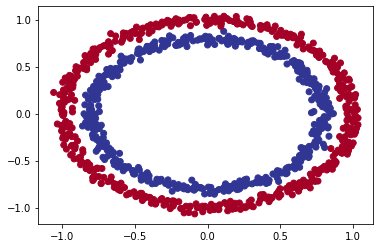

In [5]:
# Visualize data
import matplotlib.pyplot as plt

plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

## 1.1 Check input and output shapes

In [6]:
X.shape, y.shape #data is in shape of numpy arrays

((1000, 2), (1000,))

In [7]:
# View the first examples of features and samples
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and same for y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and same for y: 1
Shape for one sample of X: (2,) and same for y: ()


## 1.2 Turn data into Tensors and create train/test splits

In [8]:
import torch
torch.__version__

'1.13.1+cu116'

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [11]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [12]:
# Split data into training/test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots

To Do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training and test loop

In [14]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've set up device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create two `nn.Linear` layers that are capable of handling the shapes of our data
3. Define a 'forward()` method that outlines the forward pass of the model
4. Instantiate an instance of our model class and send it to the target `device`

`nn.Linear()` applies the fn: `y=xA^T+b` = (input * weightTensor(transposed) + bias)

In [16]:
X_train.shape

torch.Size([800, 2])

In [17]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create two nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5, #takes 2 features and upscales to 5
                             device=device)
    self.layer_2 = nn.Linear(in_features=5, #in_features of a subsequent layer must match the out_features of the previous layer
                             out_features=1,
                             device=device) 
    
    # 3. Define a forward method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(X)) # x-> layer_1 -> layer_2 -> output

# 4. Instantiate instance of our model class and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
# Let's replicate the model above by using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

# Could replace code in step 2 in our CircleModelV0 class with the code in this cell 

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.0531, -0.3507],
                      [ 0.2055, -0.6390],
                      [-0.4677,  0.3461],
                      [ 0.7053,  0.0764],
                      [-0.3474, -0.4389]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0767,  0.2621,  0.5497,  0.3287, -0.5415], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3677, -0.0384, -0.1106, -0.0016, -0.1482]], device='cuda:0')),
             ('1.bias', tensor([0.2581], device='cuda:0'))])

In [21]:
# Make some predictions with untrained model

with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print("\n")
print(f"First 10 predictions: {torch.round(untrained_preds[:10])}")
print(f"First 10 labels: {y_test[:10]}")
print(f"Length of test labels: {len(y_test)}, Shape: {y_test.shape}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])


First 10 predictions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
Length of test labels: 200, Shape: torch.Size([200])


### Setup loss function & optimizer

Which loss and optimizer should we use? Again.. this is problem specific

For regression you may want MAE or MSE (mean absolute or mean squared error)

For classification you may want binary crossentropy or categorical crossentropy such as `nn.L1Loss`, `nn.BCELoss`

As for optimizers, torch.optim has many built in options such as `optim.SGD` and `optim.Adam`

 * For our loss function we are goint to use `torch.nn.BCEWithLogitsLoss()` 


In [22]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.0531, -0.3507],
                      [ 0.2055, -0.6390],
                      [-0.4677,  0.3461],
                      [ 0.7053,  0.0764],
                      [-0.3474, -0.4389]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0767,  0.2621,  0.5497,  0.3287, -0.5415], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3677, -0.0384, -0.1106, -0.0016, -0.1482]], device='cuda:0')),
             ('1.bias', tensor([0.2581], device='cuda:0'))])

In [23]:
# Setup the loss funciton & optimizer

# nn.BCELoss() requires inputs to have gone through sigmoid acitvation function prior to input into BCE
loss_fn = nn.BCEWithLogitsLoss() # has the sigmoid activation function built in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1) # lr = amount optimizer will adjust parameters with each epoch

In [24]:
# Calculate accuracy - out of 100 examples, what %age does our model get right?

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() #torch.eq() calculates how many of arg1 == arg2
  acc = (correct/len(y_pred)) * 100
  return acc 

## 3. Training a model

To train our model we are going to need to build a training loop

1. Forward pass through our model `model(X_train)`
2. Calculate the loss `loss_fn()`
3. Set optimizer gradients to zero `zero_grad()`
4. Perform backpropagation on loss `.backward()`
5. Step the optimizer (gradient descent) `optimizer.step()`

### 3.1 Going from raw predictions (logits) -> Prediction Probabilities -> Prediction Labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them into an activation function (eg. `sigmoid` for binary classification and `softmax` for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either roudning them or taking the argmax().

In [25]:
# View first 5 raw outputs of forward pass on the test data
 
with torch.inference_mode():  
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1994],
        [0.2222],
        [0.2397],
        [0.1875],
        [0.3987]], device='cuda:0')

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

We need our logits and test data in the same format

In [27]:
# Use sigmoid activation function on our model logits to turn them into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5497],
        [0.5553],
        [0.5596],
        [0.5468],
        [0.5984]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [28]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [29]:
len(y_test)

200

### 3.2 Building a training and testing loop

In [30]:
# Set random seed on gpu
torch.cuda.manual_seed(42)

# Set num of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building a training and evaluation loop
for epoch in range(epochs):

  #Put model in training mode
  model_0.train()

  # 1. Forward pass (model output raw logits)
  y_logits = model_0(X_train).squeeze() # reduce extra `1` dimensions
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits (input) -> pred probs -> pred labels

  # 2. Calculate the loss/accuracy
  loss = loss_fn(y_logits, y_train) #nn.BCEWithLogitsLoss() loss_fn expects LOGITS as its input, while nn.BCELoss() expects PREDICTION PROBABILITIES as input
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) if using nn.BCELoss
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Set optimizer to zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on loss fn
  loss.backward()

  # 5. Optimzer step - update parameters to reduce gradient (gradient descent)
  optimizer.step()


  ### Testing loop

  # Put model in eval mode
  model_0.eval()

  with torch.inference_mode():

    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss/accuracy
    test_loss = loss_fn(test_logits, 
                        y_test)
    test_acc = accuracy_fn(y_true = y_test, 
                           y_pred = test_pred)
    
    # Print out model status every 10 epochs
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.70520, Accuracy: 50.00% | Test loss: 0.70304, Test acc: 50.00%
Epoch: 10 | Loss: 0.69824, Accuracy: 50.00% | Test loss: 0.69661, Test acc: 50.00%
Epoch: 20 | Loss: 0.69552, Accuracy: 50.12% | Test loss: 0.69420, Test acc: 50.50%
Epoch: 30 | Loss: 0.69440, Accuracy: 55.12% | Test loss: 0.69331, Test acc: 60.00%
Epoch: 40 | Loss: 0.69390, Accuracy: 52.25% | Test loss: 0.69301, Test acc: 56.00%
Epoch: 50 | Loss: 0.69364, Accuracy: 50.75% | Test loss: 0.69295, Test acc: 54.50%
Epoch: 60 | Loss: 0.69348, Accuracy: 50.50% | Test loss: 0.69298, Test acc: 53.50%
Epoch: 70 | Loss: 0.69337, Accuracy: 49.88% | Test loss: 0.69306, Test acc: 54.50%
Epoch: 80 | Loss: 0.69330, Accuracy: 49.75% | Test loss: 0.69315, Test acc: 54.00%
Epoch: 90 | Loss: 0.69323, Accuracy: 50.00% | Test loss: 0.69325, Test acc: 52.50%


## 4. Make predictions and evaluate the model 

From the metrics it looks like our model isn't learning anything... 

So to inspect it, lets make some predictions an dmake them visual

In other words, "visualize, visualize, visualize"

To do so: we are going to import a function called `plot_decision_bounadry()`

In [31]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)

if Path("helper_functions.py").is_file():
  print("helper_functions.py  already exists, skipping download.")
else:
  print("Downloading helper_functions.py ...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

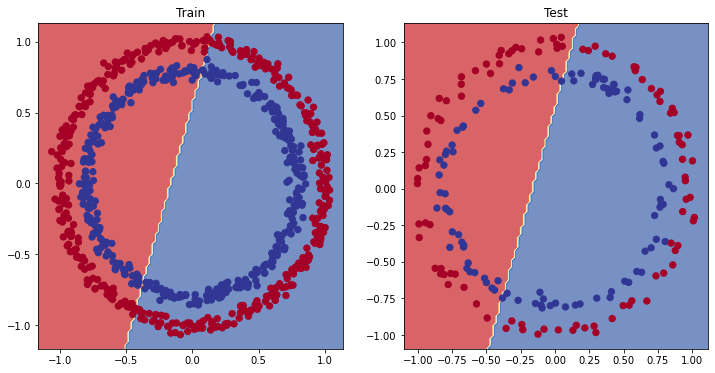

In [32]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

More on decision boundaries: https://towardsdatascience.com/a-visual-introduction-to-neural-networks-68586b0b733b


## 5. Improving a model (from a model perspective)

* **Add more layers** - give model a chance to learn more about patterns in the data
* **Add more hidden units** - go from 5 hidden units to 10 hidden units
* **Fit for longer** (more epochs)
* **Changing the activation functions**
* **Change the learning rate**
* **Change the loss fn**

These optioins are all from the model's perspective as these changes all deal with the model and not the data.

And because these options are all values we as ML engineers/data scientists can changes, they are referred to as *hyperparameters*

Lets try and improve our model by:
* Adding more hidden units: 5->10
* Increase the number of layers: 2->3
* Increase the number of epochs: 100->1000

In [38]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, 
                             out_features=10)
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)
    
  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups of operations behind the scenes

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0

In [40]:
# Create a loss function

loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer

optimizer = torch.optim.SGD(params = model_1.parameters(),
                      lr=0.1)

In [36]:
!nvidia-smi

Wed Mar  8 15:25:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    34W /  70W |    805MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
# Set random seed + on gpu
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set num of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### Build a training loop for model_1

for epoch in range(epochs):
  
  model_1.train()

  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Step optimizer (GD)
  optimizer.step()

### Build a testing loop for model_1

  model_1.eval()

  with torch.inference_mode():

    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calc loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, 
                           y_pred = test_pred)

    # Print out model status every 10 epochs
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69389, Accuracy: 50.62% | Test loss: 0.69263, Test acc: 50.50%
Epoch: 100 | Loss: 0.69304, Accuracy: 50.62% | Test loss: 0.69381, Test acc: 47.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69438, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


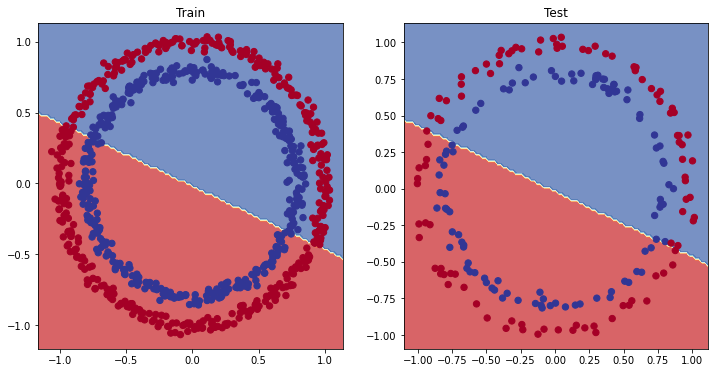

In [44]:
# Plot decision boundary for model_1
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing our data to see if model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem

In [60]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias #linear regression formula 

# Check data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [61]:
# Create train / test splits

train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]


len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

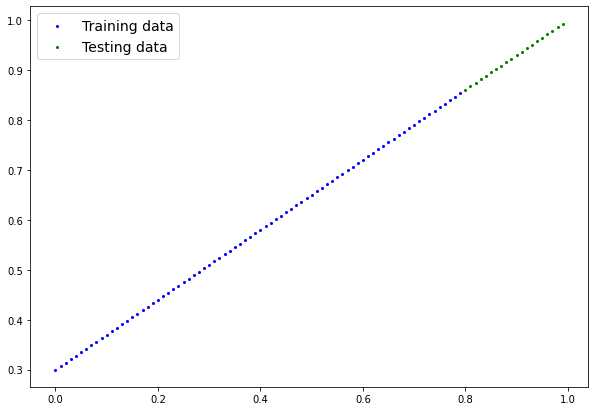

In [62]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression, 
                 predictions=None);

### 5.2 Adjust `model_1` to fit a straight line

In [51]:
model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5399,  0.5868],
                      [-0.1618,  0.6521],
                      [-0.1579,  0.1408],
                      [-0.3461,  0.4142],
                      [ 0.6176, -0.5224],
                      [ 0.6211,  0.1368],
                      [ 0.5210,  0.0951],
                      [ 0.3388, -0.1010],
                      [ 0.5338,  0.0974],
                      [-0.3410,  0.1731]])),
             ('layer_1.bias',
              tensor([-0.3256, -0.0830, -0.2871,  0.4692, -0.5580, -0.3260, -0.1995, -0.4250,
                       0.0671, -0.6982])),
             ('layer_2.weight',
              tensor([[ 0.2973, -0.2652,  0.2434,  0.0517, -0.0992,  0.2043,  0.0567,  0.2590,
                        0.0422, -0.1024],
                      [ 0.0644, -0.0915,  0.1344,  0.2843,  0.1761, -0.1541,  0.1695,  0.0502,
                        0.1472, -0.1882],
                      [-0.2934, -0.1167, -0.2438,  0.2577,  0.0973,  0.1461,  0.1125, 

In [68]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [73]:
# Loss and optimizer
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_2.parameters(), 
                            lr=0.01)

In [74]:
# Train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):

  ### TRAIN LOOP
  # Foward pass
  y_pred = model_2(X_train_regression)

  # Calculate loss
  loss = loss_fn(y_pred, y_train_regression)

  # Set gradient to zero
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Step optimizer
  optimizer.step()

  ### TEST LOOP
  model_2.eval()

  with torch.inference_mode():

    # Foward pass
    test_pred = model_2(X_test_regression)

    # Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out model status every 10 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.06466 | Test loss: 0.12597
Epoch: 100 | Loss: 0.00743 | Test loss: 0.00093
Epoch: 200 | Loss: 0.00621 | Test loss: 0.00123
Epoch: 300 | Loss: 0.00619 | Test loss: 0.00116
Epoch: 400 | Loss: 0.00617 | Test loss: 0.00094
Epoch: 500 | Loss: 0.00646 | Test loss: 0.00138
Epoch: 600 | Loss: 0.00614 | Test loss: 0.00110
Epoch: 700 | Loss: 0.00612 | Test loss: 0.00103
Epoch: 800 | Loss: 0.00641 | Test loss: 0.00149
Epoch: 900 | Loss: 0.00639 | Test loss: 0.00118


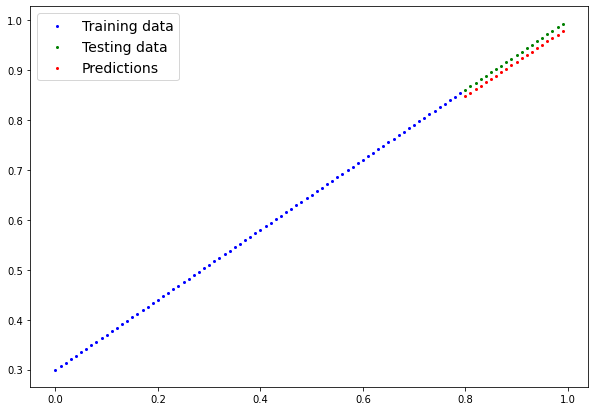

In [83]:
# Turn on eval mode
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: Non-linearity

What patterns could you draw if you were given an infinite amount of straight and non-straight lines? 

Or in ML terms, an infinite (but really finite) amount of linear and non-linear functions?

### 6.1 Recreating non-linear data (red/blue circles)

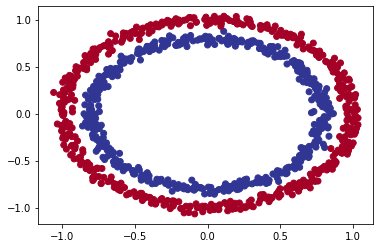

In [127]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [128]:
# Convert data to tensors and split into train and test splits
import torch 
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [129]:
# Build a model with a non-linear activation function
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() #non-linear function: all neg inputs = 0

  def forward(self, x):
    # Where should we put out non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [130]:
# Setup loss function and optimizer
loss = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_3.parameters(),
                         lr = 0.1)

In [131]:
# Create training and testing loops

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put train/test data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
### TRAINING LOOP
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### TEST LOOP
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)  

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.49944, Accuracy: 50.00% | Test loss: 0.49982, Test acc: 50.00%
Epoch: 100 | Loss: 0.49324, Accuracy: 50.38% | Test loss: 0.49250, Test acc: 50.00%
Epoch: 200 | Loss: 0.48305, Accuracy: 50.62% | Test loss: 0.48082, Test acc: 50.00%
Epoch: 300 | Loss: 0.45787, Accuracy: 51.00% | Test loss: 0.45079, Test acc: 51.00%
Epoch: 400 | Loss: 0.39007, Accuracy: 52.25% | Test loss: 0.37911, Test acc: 52.00%
Epoch: 500 | Loss: 0.27885, Accuracy: 59.00% | Test loss: 0.27371, Test acc: 50.00%
Epoch: 600 | Loss: 0.20875, Accuracy: 75.12% | Test loss: 0.31739, Test acc: 50.00%
Epoch: 700 | Loss: 0.15074, Accuracy: 69.62% | Test loss: 0.21243, Test acc: 52.00%
Epoch: 800 | Loss: 0.11643, Accuracy: 64.62% | Test loss: 0.15972, Test acc: 59.00%
Epoch: 900 | Loss: 0.17093, Accuracy: 84.50% | Test loss: 0.28401, Test acc: 50.00%
